In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pedpy

# from shapely import GeometryCollection, Polygon
from pathlib import Path
import glob
import os
import jupedsim as jps
from shapely.geometry import Polygon  # , LineString

Define Room and Corridor Geometry


In [2]:
room1 = Polygon([(0, 0), (10, 0), (10, 10), (0, 10)])  # Room 1 (10m x 10m)
room2 = Polygon([(15, 0), (25, 0), (25, 10), (15, 10)])  # Room 2 (10m x 10m)
corridor_widths = [1.0, 1.2, 1.4]  # Corridor widths to test

Simulation Parameters


In [3]:
# Clean up a bit!
sqlite_files = glob.glob("*.sqlite")
for sqlite_file in sqlite_files:
    # remove all the files
    print(f"Removing {sqlite_file}")
    os.remove(sqlite_file)

## Measeaurement method for flow

In [4]:
def calculate_flow_rate(trajfile, measurement_line):
    traj = pedpy.load_trajectory_from_jupedsim_sqlite(trajfile)
    nt, _ = pedpy.compute_n_t(
        traj_data=traj,
        measurement_line=measurement_line,
    )
    num_agents_crossed = nt["cumulative_pedestrians"].max()
    first = nt[nt["cumulative_pedestrians"] != 0]["time"].iloc[0]
    last = nt["time"].iloc[-1]
    flow = num_agents_crossed / (last - first)
    return flow

## Simulation loop for different seed values

In [5]:
flow_rates_all = {width: [] for width in corridor_widths}
seeds = np.random.randint(0, 1000, 10)
measurement_line = pedpy.MeasurementLine([(10, 0), (10, 10)])
num_agents = 200  # Number of agents to simulate
trajectory_file_base = "bottleneck_simulation"

for seed in seeds:
    for width in corridor_widths:
        # Define corridor with variable width
        corridor = Polygon(
            [
                (10, 5 - width / 2),
                (15, 5 - width / 2),
                (15, 5 + width / 2),
                (10, 5 + width / 2),
            ]
        )
        area = room1.union(room2).union(
            corridor
        )  # Combine the room and corridor geometries
        trajfile = pathlib.Path(f"{trajectory_file_base}_{width}_{seed}.sqlite")
        # Define Exit Area (at the end of the corridor)
        exit_area = Polygon(
            [(24, 4.5), (25, 4.5), (25, 5.5), (24, 5.5)]
        )  # Place exit within walkable area
        exit_boundary = exit_area.exterior.coords
        # Initialize simulation
        simulation = jps.Simulation(
            model=jps.CollisionFreeSpeedModel(
                # strength_geometry_repulsion=1
                #strength_neighbor_repulsion=2,
                #range_neighbor_repulsion=0.5,
            ),
            geometry=area,
            trajectory_writer=jps.SqliteTrajectoryWriter(
                output_file=trajfile
            ),
        )

        # Add Exit Area to the simulation (pass the exit boundary as a LineString)
        exit_id = simulation.add_exit_stage(exit_boundary)
        journey = jps.JourneyDescription([exit_id])
        journey_id = simulation.add_journey(journey)

        # Define Starting Area (all agents start in Room 1)
        # this is constant and independent of the corridor width
        spawning_area = Polygon(
            [(0, 0), (5, 0), (5, 10), (0, 10)]
        )  # Use entire room for spawning
        positions = jps.distributions.distribute_by_number(
            polygon=spawning_area,
            number_of_agents=num_agents,
            distance_to_agents=0.3,  # Increase distance to avoid overlap
            distance_to_polygon=0.15,  # Increase distance to polygon boundary
            seed=seed,
        )

        # Add Agents to the Simulation
        for position in positions:
            agent_params = jps.CollisionFreeSpeedModelAgentParameters(
                journey_id=journey_id,  # Journey where agents go
                stage_id=exit_id,  # The exit stage
                position=position,  # Starting position of the agent
                radius=0.15,  # The agent's radius
            )
            simulation.add_agent(agent_params)  # Adding agent parameters correctly

        # Run Simulation until all agents have crossed the exit
        while simulation.agent_count() > 0 and simulation.iteration_count() < 100000:
            simulation.iterate()

        print(f"Seed = {seed}, Corridor width = {width} m, Simulation time: {simulation.elapsed_time(): .2f} s")
        flow = calculate_flow_rate(trajfile, measurement_line)
        flow_rates_all[width].append(flow)


Seed = 169, Corridor width = 1.0 m, Simulation time:  146.04 s
Seed = 169, Corridor width = 1.2 m, Simulation time:  130.60 s
Seed = 169, Corridor width = 1.4 m, Simulation time:  105.50 s
Seed = 132, Corridor width = 1.0 m, Simulation time:  143.52 s
Seed = 132, Corridor width = 1.2 m, Simulation time:  133.87 s
Seed = 132, Corridor width = 1.4 m, Simulation time:  109.51 s
Seed = 224, Corridor width = 1.0 m, Simulation time:  142.83 s
Seed = 224, Corridor width = 1.2 m, Simulation time:  132.45 s
Seed = 224, Corridor width = 1.4 m, Simulation time:  106.46 s
Seed = 378, Corridor width = 1.0 m, Simulation time:  143.42 s
Seed = 378, Corridor width = 1.2 m, Simulation time:  124.68 s
Seed = 378, Corridor width = 1.4 m, Simulation time:  107.88 s
Seed = 831, Corridor width = 1.0 m, Simulation time:  143.33 s
Seed = 831, Corridor width = 1.2 m, Simulation time:  129.28 s
Seed = 831, Corridor width = 1.4 m, Simulation time:  105.61 s
Seed = 313, Corridor width = 1.0 m, Simulation time:  1

## Analysis - Flow


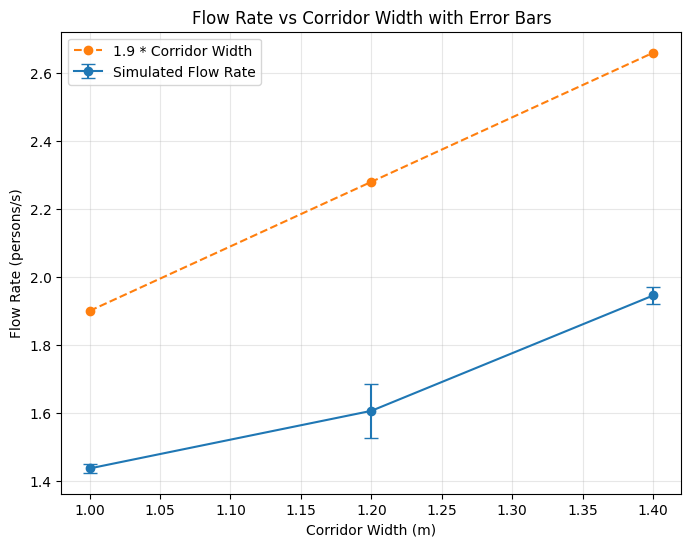

Mean Flow Rates: [1.4362320548066139, 1.6058529501556649, 1.9454730557734756]
Standard Deviations: [0.012582580878176146, 0.07901734593974821, 0.02568343390584072]


In [6]:
mean_flow_rates = []
std_flow_rates = []
for width in corridor_widths:
    flows = flow_rates_all[width]
    mean_flow_rates.append(np.mean(flows))
    std_flow_rates.append(np.std(flows))

# Plot results with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    corridor_widths,
    mean_flow_rates,
    yerr=std_flow_rates,
    fmt="o-",
    capsize=5,
    label="Simulated Flow Rate",
)
plt.plot(
    corridor_widths,
    np.array(corridor_widths) * 1.9,
    "o--",
    label="1.9 * Corridor Width",
)
plt.xlabel("Corridor Width (m)")
plt.ylabel("Flow Rate (persons/s)")
plt.title("Flow Rate vs Corridor Width with Error Bars")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Mean Flow Rates:", mean_flow_rates)
print("Standard Deviations:", std_flow_rates)